In [1]:
import torch 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
import os
dir_path = '/kaggle/input/fracture-classification-dataset/FracAtlas/images'
def walk_through_dir(dir_path):
    for dirpath , dirnames, filnames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filnames)} images in {dir_path}")

In [3]:
walk_through_dir(dir_path)

There are 2 directories and 0 images in /kaggle/input/fracture-classification-dataset/FracAtlas/images
There are 0 directories and 3366 images in /kaggle/input/fracture-classification-dataset/FracAtlas/images
There are 0 directories and 717 images in /kaggle/input/fracture-classification-dataset/FracAtlas/images


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [6]:
import os
import shutil
import torch
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

def split_and_save_dataset(dataset, output_dir='/kaggle/working', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    """
    Split a dataset into training, validation, and test sets and save them to separate directories.
    
    Args:
        dataset (torchvision.datasets.ImageFolder): The dataset to be split.
        output_dir (str): The base directory to save the split datasets.
        train_ratio (float): The ratio of the dataset to be used for the training set.
        val_ratio (float): The ratio of the dataset to be used for the validation set.
        test_ratio (float): The ratio of the dataset to be used for the test set.
        seed (int): The seed for the random split.
    
    Returns:
        tuple: (train_dir, val_dir, test_dir) - paths to the created directories
    """
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of train_ratio, val_ratio, and test_ratio must be 1.0.")
    
    torch.manual_seed(seed)
    dataset_size = len(dataset)
    
    train_size = int(dataset_size * train_ratio)
    val_size = int(dataset_size * val_ratio)
    test_size = dataset_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    # Create directories
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')
    
    for dir_path in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path)
    
    # Function to copy files
    def copy_files(src_dataset, dest_dir):
        for idx in src_dataset.indices:
            src_path, label = dataset.samples[idx]
            class_name = dataset.classes[label]
            dest_class_dir = os.path.join(dest_dir, class_name)
            os.makedirs(dest_class_dir, exist_ok=True)
            shutil.copy2(src_path, dest_class_dir)
    
    # Copy files to respective directories
    copy_files(train_dataset, train_dir)
    copy_files(val_dataset, val_dir)
    copy_files(test_dataset, test_dir)
    
    print(f"Dataset split and saved to {output_dir}")
    print(f"Train set: {train_size} images")
    print(f"Validation set: {val_size} images")
    print(f"Test set: {test_size} images")
    
    return train_dir, val_dir, test_dir

# Usage
data_dir = '/kaggle/input/fracture-classification-dataset/FracAtlas/images'
dataset = ImageFolder(data_dir)

train_dir, val_dir, test_dir = split_and_save_dataset(dataset)

Dataset split and saved to /kaggle/working
Train set: 3266 images
Validation set: 408 images
Test set: 409 images


In [23]:
from pathlib import Path
train_dir = Path('/kaggle/working/train')
val_dir = Path('/kaggle/working/val')
val_dir , train_dir

(PosixPath('/kaggle/working/val'), PosixPath('/kaggle/working/train'))

       Non_fractured  Fractured
train           2696        570
     Non_fractured  Fractured
val            333         75


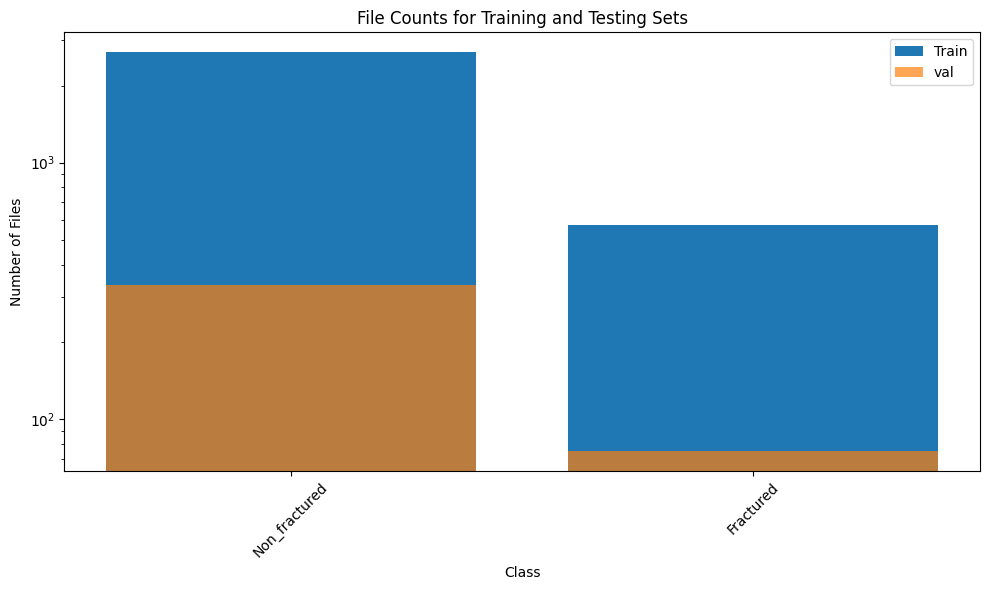

In [7]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

# Define a function to count the number of files for each subdirectory in a given directory.
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len([file for file in os.listdir(item_path) if os.path.isfile(os.path.join(item_path, file))])

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/val'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'val')
print(test_count)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot training data
plt.bar(train_count.columns, train_count.loc['train'], label='Train')

# Plot testing data
plt.bar(test_count.columns, test_count.loc['val'], label='val', alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Number of Files')
plt.title('File Counts for Training and Testing Sets')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yscale("log")
plt.tight_layout()  # Ensure labels fit within the figure area
plt.show()

Random image path: /kaggle/working/test/Fractured/IMG0003301.jpg
Image class: Fractured
Image height: 454
Image width: 373


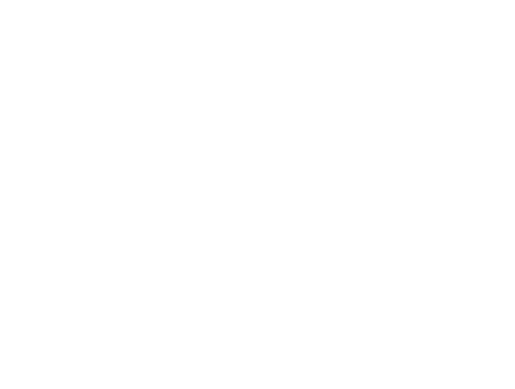

In [7]:
import random
from PIL import Image
from pathlib import Path

# Use the path you provided
img_path = '/kaggle/working/test/Fractured'

# Set seed
random.seed(42)

# Convert image_path to a Path object
image_path = Path(img_path)

# 1. Get all image paths (checking for multiple formats)
image_path_list = list(image_path.glob("*.jpeg")) + \
                  list(image_path.glob("*.jpg")) + \
                  list(image_path.glob("*.png"))

if not image_path_list:
    print("No image files found. Please check the directory structure and file formats.")
    
    # Let's print the contents of the directory to see what's there
    print("\nContents of the directory:")
    for item in image_path.iterdir():
        print(item)
else:
    # 2. Get random image path
    random_image_path = random.choice(image_path_list)

    # 3. Get image class from path name (in this case, it will always be 'NORMAL')
    image_class = random_image_path.parent.name

    # 4. Open image
    img = Image.open(random_image_path)

    # 5. Print metadata
    print(f"Random image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.height}") 
    print(f"Image width: {img.width}")

    # Display the image (this might not work in Kaggle notebooks)
    # img.show()

    # Instead, let's use matplotlib to display the image
    import matplotlib.pyplot as plt
#     plt.imshow(img, cmap='gray')  # 'gray' colormap for X-ray images
    plt.axis('off')
#     plt.show()

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

def check_image_shapes(data):
    shape_counts = defaultdict(int)
    channel_counts = defaultdict(int)

    if isinstance(data, Dataset):
        for i in range(len(data)):
            img, _ = data[i]
            process_image(img, i, shape_counts, channel_counts)
    elif isinstance(data, DataLoader):
        for i, batch in enumerate(data.dataset):
            img, _ = batch
            process_image(img, i, shape_counts, channel_counts)
    else:
        raise TypeError("Input must be a PyTorch Dataset or DataLoader")

    print_results(shape_counts, channel_counts)
    return shape_counts, channel_counts

def process_image(img, index, shape_counts, channel_counts):
    if not isinstance(img, torch.Tensor):
        raise TypeError(f"Item {index} is not a torch.Tensor")
    
    shape = tuple(img.shape)
    shape_counts[shape] += 1
    channel_counts[shape[0]] += 1

def print_results(shape_counts, channel_counts):
    print("Image shape distribution:")
    for shape, count in shape_counts.items():
        print(f"  Shape {shape}: {count} images")

    print("\nChannel count distribution:")
    for channels, count in channel_counts.items():
        print(f"  {channels} channel(s): {count} images")

    if len(shape_counts) > 1:
        print("\nWARNING: Inconsistent image shapes detected!")
    else:
        print("\nAll images have consistent shape.")

# Usage example:
# shape_counts, channel_counts = check_image_shapes(train_dataloader_custom)

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
dir_1 = '/kaggle/working/'

In [26]:
from pathlib import Path
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir( Path(dir_1)/ "train"))])
print(f"Class names found: {class_names_found}")

Target directory: /kaggle/working/train
Class names found: ['Fractured', 'Non_fractured']


In [14]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [28]:
find_classes(train_dir)

(['Fractured', 'Non_fractured'], {'Fractured': 0, 'Non_fractured': 1})

In [29]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        try:
            img = self.load_image(index)
            class_name = self.paths[index].parent.name
            class_idx = self.class_to_idx[class_name]
            if self.transform:
                return self.transform(img), class_idx
            else:
                return img, class_idx
        except Exception as e:
            print(f"Error loading image at index {index}: {self.paths[index]}")
            print(f"Error message: {str(e)}")
        # Return a placeholder image or skip this sample
        return torch.zeros((3, 224, 224)), -1  # Example placeholder

In [30]:
train_transforms = transforms.Compose([ 
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])  

val_transforms = transforms.Compose([ 
    transforms.Resize((512,512)),
    transforms.ToTensor(),
])  

In [66]:
import torch
from torch.utils.data import DataLoader

def custom_collate(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Ensure all images have 3 channels
    images = [img.expand(3, -1, -1) if img.size(0) == 1 else img for img in images]
    
    return torch.stack(images), torch.tensor(labels)

In [32]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
val_data_custom = ImageFolderCustom(targ_dir=val_dir, 
                                     transform=val_transforms)
train_data_custom, val_data_custom
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=32,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True,
                                     collate_fn=custom_collate)
val_dataloader_custom = DataLoader(dataset=val_data_custom,
                                     batch_size=32,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True,
                                     collate_fn=custom_collate)
val_dataloader_custom, train_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c20b90b5990>,
 <torch.utils.data.dataloader.DataLoader at 0x7c216754baf0>)

In [33]:
len(train_data_custom), len(val_data_custom)

(3266, 408)

In [34]:
train_data_custom.classes ,train_data_custom.class_to_idx

(['Fractured', 'Non_fractured'], {'Fractured': 0, 'Non_fractured': 1})

In [35]:
class_names = train_data_custom.classes

In [22]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

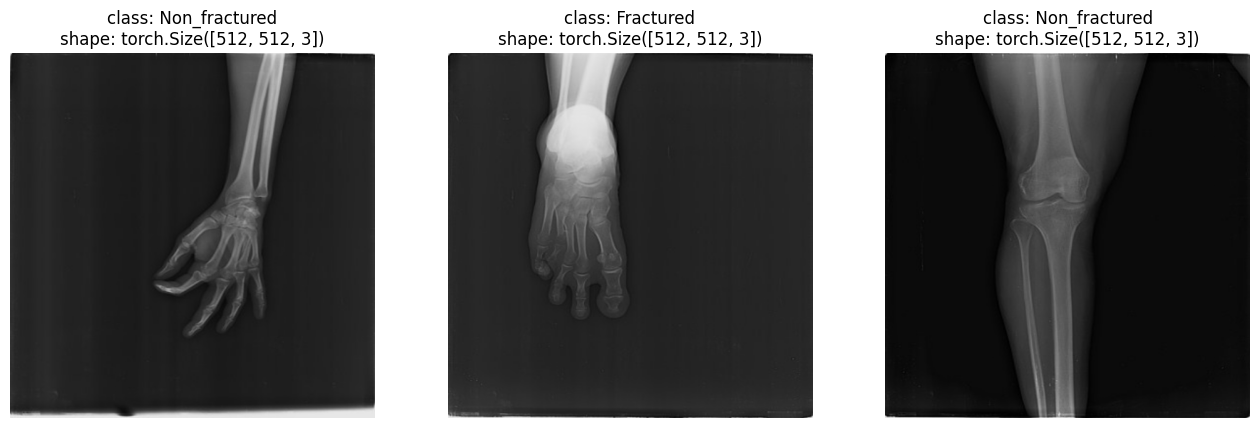

In [23]:
display_random_images(train_data_custom, 
                      n=3, 
                      classes=class_names,
                      seed=None)

In [24]:
import torch
from torch.utils.data import DataLoader



# Load a batch
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Batch shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")

channel_counts = [img.size(0) for img in img_custom]
unique_channel_counts = set(channel_counts)
print(f"Unique channel counts: {unique_channel_counts}")

print(f"All images have 3 channels: {all(count == 3 for count in channel_counts)}")
print(f"Unique label values: {torch.unique(label_custom)}")

has_nan = torch.isnan(img_custom).any()
print(f"Batch contains NaN values: {has_nan}")

print(f"Min value in batch: {img_custom.min()}")
print(f"Max value in batch: {img_custom.max()}")

Batch shape: torch.Size([32, 3, 512, 512])
Label shape: torch.Size([32])
Unique channel counts: {3}
All images have 3 channels: True
Unique label values: tensor([0, 1])
Batch contains NaN values: False
Min value in batch: 0.0
Max value in batch: 0.9882352948188782


In [36]:
from torchvision import datasets, io, models, ops, transforms, utils
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

In [37]:
weights = models.ResNet50_Weights.DEFAULT 
model_transfer = models.resnet50(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 


In [38]:
for param in model_transfer.parameters():
    param.requires_grad = False

for param in model_transfer.layer4.parameters():
    param.requires_grad = True

# Unfreeze the final fully connected layer
for param in model_transfer.fc.parameters():
    param.requires_grad = True

In [39]:
model_transfer.fc = nn.Linear(in_features=model_transfer.fc.in_features, out_features=2).to(device)

In [40]:
from torchinfo import summary

summary(model=model_transfer, 
        input_size=(32, 3, 512, 512), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 512, 512]    [32, 2]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 512, 512]    [32, 64, 256, 256]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 256, 256]   [32, 64, 256, 256]   (128)                False
├─ReLU (relu)                            [32, 64, 256, 256]   [32, 64, 256, 256]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 256, 256]   [32, 64, 128, 128]   --                   --
├─Sequential (layer1)                    [32, 64, 128, 128]   [32, 256, 128, 128]  --                   False
│    └─Bottleneck (0)                    [32, 64, 128, 128]   [32, 256, 128, 128]  --                   False
│    │    └─Conv2d (conv1)               [32, 64, 128, 128]   [32, 64, 128, 128]   (4,096)              False
│    │    

In [64]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transfer.parameters(), lr=0.001) 

In [42]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [43]:
def eval_step(model, dataloader, loss_fn, device):
    model.eval() 
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(y))
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [44]:
def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs, device):
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        val_loss, val_acc = eval_step(model, val_dataloader, loss_fn, device)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
    return results

In [67]:
epochs = 25 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
results = train_model(model=model_transfer,
                      train_dataloader=train_dataloader_custom,
                      val_dataloader=val_dataloader_custom,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=epochs,
                      device=device)


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.0738 | train_acc: 0.9730 | val_loss: 0.7892 | val_acc: 0.8470
Epoch: 2 | train_loss: 0.0382 | train_acc: 0.9885 | val_loss: 0.5638 | val_acc: 0.8638
Epoch: 3 | train_loss: 0.0178 | train_acc: 0.9954 | val_loss: 0.8075 | val_acc: 0.8806
Epoch: 4 | train_loss: 0.0276 | train_acc: 0.9906 | val_loss: 1.1969 | val_acc: 0.8734
Epoch: 5 | train_loss: 0.0147 | train_acc: 0.9958 | val_loss: 1.5060 | val_acc: 0.8726
Epoch: 6 | train_loss: 0.0166 | train_acc: 0.9930 | val_loss: 1.1055 | val_acc: 0.8710
Epoch: 7 | train_loss: 0.0107 | train_acc: 0.9973 | val_loss: 1.1057 | val_acc: 0.8710
Epoch: 8 | train_loss: 0.0648 | train_acc: 0.9824 | val_loss: 0.5168 | val_acc: 0.8774
Epoch: 9 | train_loss: 0.1130 | train_acc: 0.9554 | val_loss: 0.8915 | val_acc: 0.8862
Epoch: 10 | train_loss: 0.0353 | train_acc: 0.9894 | val_loss: 0.6354 | val_acc: 0.8870
Epoch: 11 | train_loss: 0.0644 | train_acc: 0.9760 | val_loss: 0.7111 | val_acc: 0.8782
Epoch: 12 | train_loss: 0.0122 | train_ac

In [72]:
import matplotlib.pyplot as plt
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

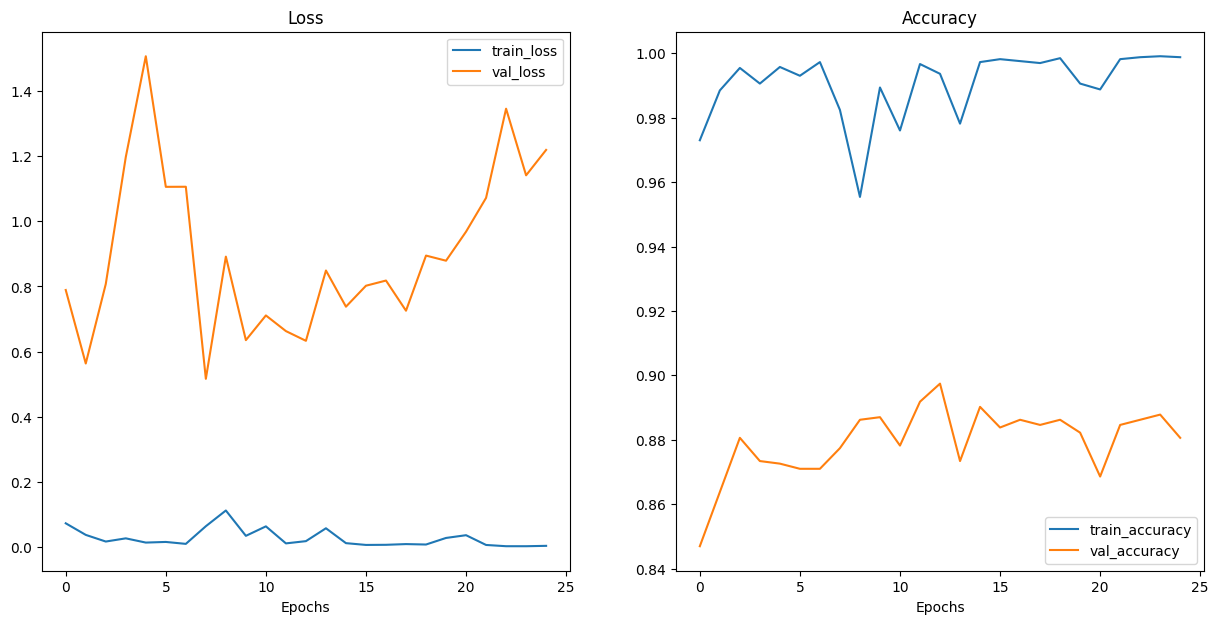

In [70]:
plot_loss_curves(results)

In [74]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, class_names):
    """
    Plot a confusion matrix for a PyTorch model.
    
    Args:
    model (torch.nn.Module): The trained PyTorch model
    dataloader (torch.utils.data.DataLoader): DataLoader containing the test data
    class_names (list): List of class names
    
    Returns:
    None (displays the confusion matrix plot)
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Lists to store true labels and predictions
    y_true = []
    y_pred = []
    
    # Iterate over the dataloader
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Append true labels and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


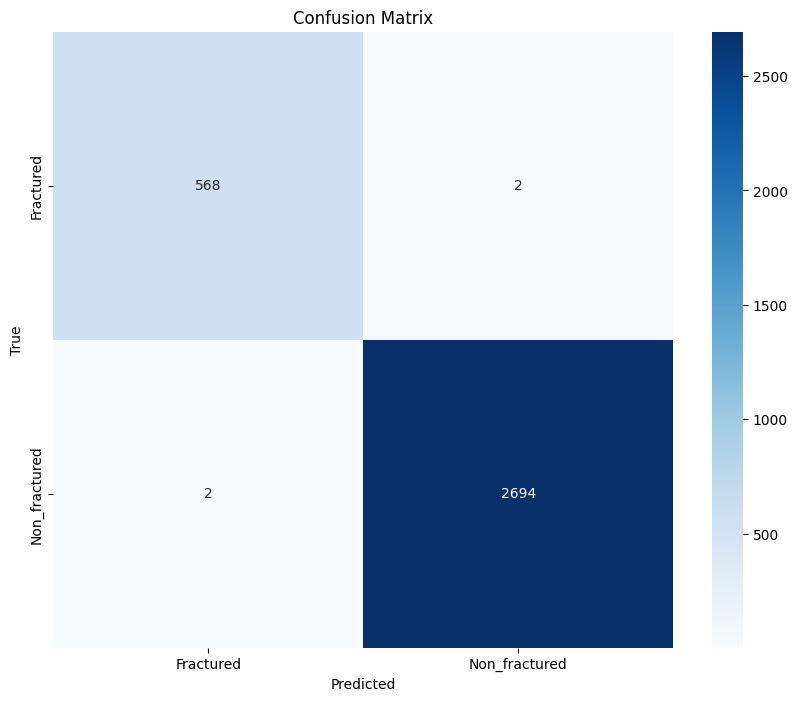

In [73]:
class_names = train_data_custom.classes

# Plot confusion matrix
plot_confusion_matrix(model_transfer, train_dataloader_custom, class_names)

In [74]:
import torch
from torch.nn import functional as F
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate precision, recall, and F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
    
    # Calculate macro average (unweighted mean) of metrics
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1 = f1.mean()
    
    return precision, recall, f1, macro_precision, macro_recall, macro_f1

def print_metrics(precision, recall, f1, macro_precision, macro_recall, macro_f1, class_names):
    print("Per-class metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1[i]:.4f}")
        print()
    
    print("Macro-average metrics:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall: {macro_recall:.4f}")
    print(f"F1 Score: {macro_f1:.4f}")

In [75]:
metrics = calculate_metrics(model_transfer, val_dataloader_custom, device)

# Print metrics
print_metrics(*metrics, class_names)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Per-class metrics:
Fractured:
  Precision: 0.8000
  Recall: 0.4800
  F1 Score: 0.6000

Non_fractured:
  Precision: 0.8926
  Recall: 0.9730
  F1 Score: 0.9310

Macro-average metrics:
Precision: 0.8463
Recall: 0.7265
F1 Score: 0.7655


In [47]:
train_transforms_1 = transforms.Compose([
transforms.Resize((512, 512)),
transforms.RandomCrop((512, 512)),
transforms.RandomRotation(degrees=30),
transforms.RandomHorizontalFlip(),
transforms.RandomVerticalFlip(),
transforms.ColorJitter(brightness=0.2, contrast=0.2),
transforms.ToTensor(),
])

val_transforms_1 = transforms.Compose([
transforms.Resize((512,512)),
transforms.ToTensor(),
])

In [51]:
train_data_augmented = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms_1)
val_data_augmented = ImageFolderCustom(targ_dir=val_dir, transform=val_transforms_1)

train_data_augmented , val_data_augmented

(<__main__.ImageFolderCustom at 0x7c20b896fb80>,
 <__main__.ImageFolderCustom at 0x7c20b896fbb0>)

In [52]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
batch_size=BATCH_SIZE,
shuffle=True,
num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(val_data_augmented,
batch_size=BATCH_SIZE,
shuffle=False,
num_workers=NUM_WORKERS)

In [57]:
train_data_augmented , val_data_augmented

(<__main__.ImageFolderCustom at 0x7c20b896fb80>,
 <__main__.ImageFolderCustom at 0x7c20b896fbb0>)

In [67]:
# Import necessary libraries
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# Handle truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Extract labels manually from the dataset
labels = [data[1] for data in train_data_augmented]

# Calculate class weights based on the frequency of each class
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(labels), 
                                     y=labels)

# Convert class weights into a tensor for PyTorch
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Assign weights to each sample in the dataset based on its label
sample_weights = [class_weights[label] for label in labels]

# Create a WeightedRandomSampler to handle class imbalance
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Use the sampler in the DataLoader
train_dataloader_augmented = DataLoader(
    train_data_augmented,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    collate_fn=custom_collate
)

test_dataloader_simple = DataLoader(
    val_data_augmented,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=custom_collate
)


In [68]:
# Train the model
results = train_model(model=model_transfer,
                      train_dataloader=train_dataloader_augmented,
                      val_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=25,
                      device=device)

Epoch: 1 | train_loss: 0.4971 | train_acc: 0.7397 | val_loss: 0.4306 | val_acc: 0.8349
Epoch: 2 | train_loss: 0.4097 | train_acc: 0.8131 | val_loss: 0.3930 | val_acc: 0.8486
Epoch: 3 | train_loss: 0.4043 | train_acc: 0.8167 | val_loss: 0.4020 | val_acc: 0.8325
Epoch: 4 | train_loss: 0.3708 | train_acc: 0.8271 | val_loss: 0.4271 | val_acc: 0.8333
Epoch: 5 | train_loss: 0.3494 | train_acc: 0.8510 | val_loss: 0.4455 | val_acc: 0.8165
Epoch: 6 | train_loss: 0.3063 | train_acc: 0.8656 | val_loss: 0.3760 | val_acc: 0.8454
Epoch: 7 | train_loss: 0.3312 | train_acc: 0.8598 | val_loss: 0.3828 | val_acc: 0.8293
Epoch: 8 | train_loss: 0.3115 | train_acc: 0.8604 | val_loss: 0.3916 | val_acc: 0.8245
Epoch: 9 | train_loss: 0.2835 | train_acc: 0.8756 | val_loss: 0.3983 | val_acc: 0.8253
Epoch: 10 | train_loss: 0.2689 | train_acc: 0.8865 | val_loss: 0.4971 | val_acc: 0.8237
Epoch: 11 | train_loss: 0.2641 | train_acc: 0.8865 | val_loss: 0.4193 | val_acc: 0.8462
Epoch: 12 | train_loss: 0.2480 | train_ac

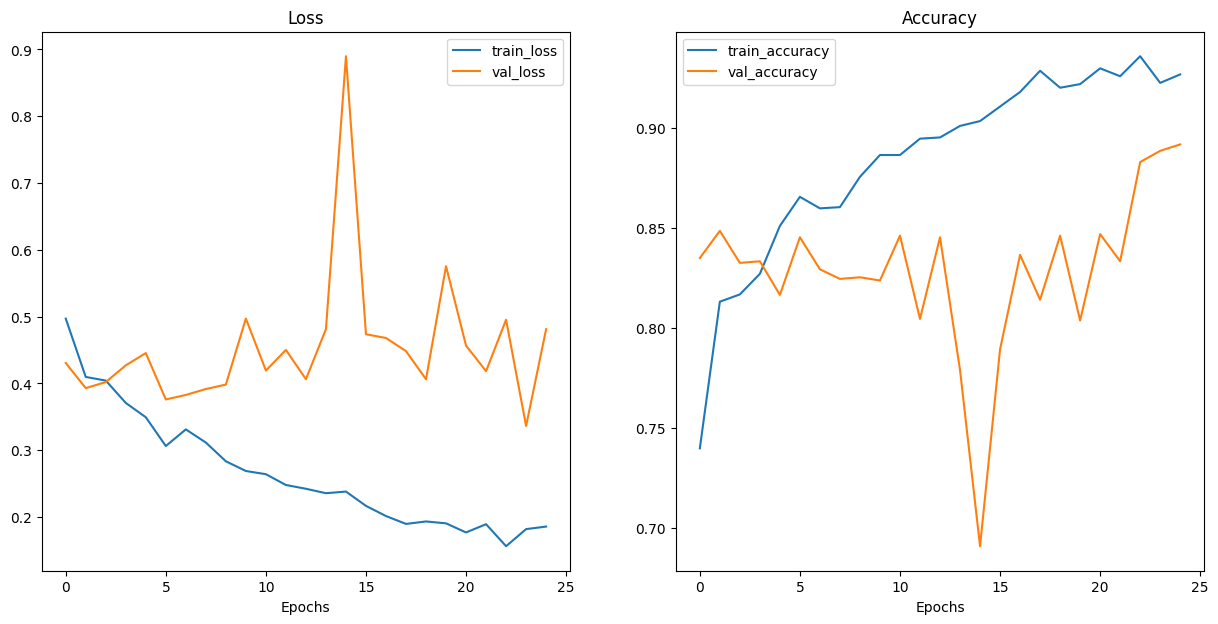

In [73]:
plot_loss_curves(results)

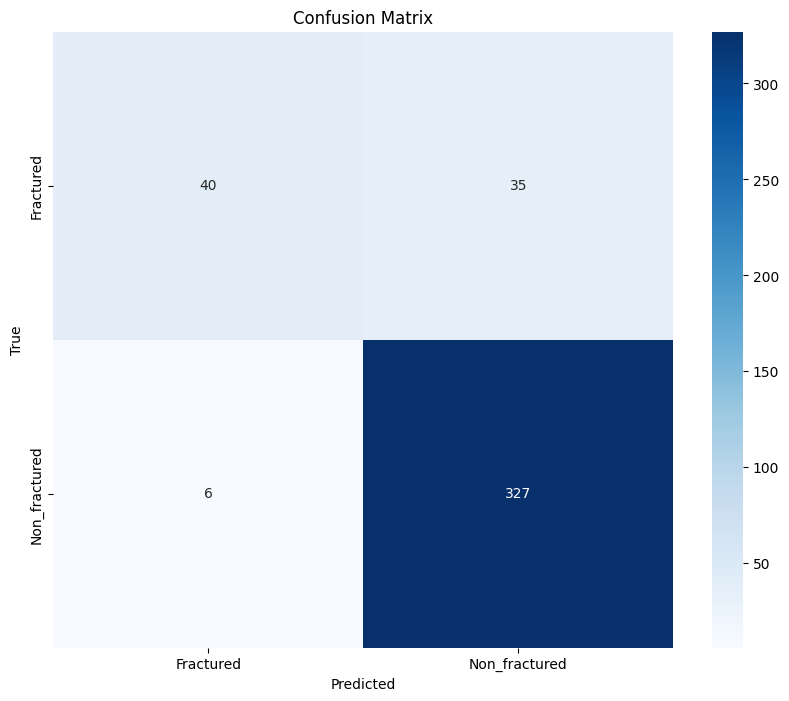

In [76]:
class_names = train_data_custom.classes

# Plot confusion matrix
plot_confusion_matrix(model_transfer, val_dataloader_custom, class_names)

In [94]:
import torch
from torch.nn import functional as F
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate precision, recall, and F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
    
    # Calculate macro average (unweighted mean) of metrics
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1 = f1.mean()
    
    return precision, recall, f1, macro_precision, macro_recall, macro_f1

def print_metrics(precision, recall, f1, macro_precision, macro_recall, macro_f1, class_names):
    print("Per-class metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1[i]:.4f}")
        print()
    
    print("Macro-average metrics:")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall: {macro_recall:.4f}")
    print(f"F1 Score: {macro_f1:.4f}")

In [95]:
metrics = calculate_metrics(model_transfer, val_dataloader_custom, device)

# Print metrics
print_metrics(*metrics, class_names)

Per-class metrics:
Fractured:
  Precision: 0.8696
  Recall: 0.5333
  F1 Score: 0.6612

Non_fractured:
  Precision: 0.9033
  Recall: 0.9820
  F1 Score: 0.9410

Macro-average metrics:
Precision: 0.8864
Recall: 0.7577
F1 Score: 0.8011


In [101]:
torch.save(model_transfer.state_dict(), 'Fracture_detection_tf.pth')
print("Model Saved")

Model Saved
